### Imports

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from neuropy import plotting
from tqdm.notebook import tqdm
from neuropy.core import Epoch
from neuropy.utils.mathutil import min_max_scaler
from neuropy import plotting
from scipy import stats
import pandas as pd
import subjects


### Decoding visualization

In [ ]:
from hfuncs import plot_in_bokeh
import bokeh.plotting as bplot

sess = subjects.nsd.ratUday2[0]
pre = sess.paradigm["pre"].flatten()
maze = sess.paradigm["maze"].flatten()
post = sess.paradigm["post"].flatten()


replay_pbe = sess.replay_radon_mua
replay_pbe_df = replay_pbe.to_dataframe()
starts = replay_pbe.starts

radon_pbe_df = replay_pbe.to_dataframe()

# up_perc = replay_pbe.up_percentile_score.values
# up_score = replay_pbe.up_score.values
# abs_up_score = np.abs(up_score)
up_posterior = replay_pbe.metadata["up_posterior"]

# down_perc = replay_pbe.up_percentile_score.values
# down_score = -replay_pbe.down_score.values
# abs_down_score = np.abs(down_score)
down_posterior = replay_pbe.metadata["down_posterior"]

up_radon = radon_pbe_df.up_score.values
up_vel = radon_pbe_df.up_velocity.values
down_radon = radon_pbe_df.down_score.values
down_vel = radon_pbe_df.down_velocity.values

best_bool = np.abs(up_radon) > np.abs(down_radon)
# score = np.zeros(len(starts))
# score[best_bool] = up_score[best_bool]
# score[~best_bool] = down_score[~best_bool]

radon = np.zeros(len(starts))
radon[best_bool] = up_radon[best_bool]
radon[~best_bool] = down_radon[~best_bool]

vel = np.zeros(len(starts))
vel[best_bool] = up_vel[best_bool]
vel[~best_bool] = down_vel[~best_bool]

# perc = np.zeros(len(starts))
# perc[best_bool] = up_perc[best_bool]
# perc[~best_bool] = down_perc[~best_bool]

posterior = [up_posterior, down_posterior]
posterior = [
    posterior[np.argmax([up_radon[_], down_radon[_]])][_] for _ in range(len(starts))
]

# starts = np.tile(starts, (2,)) - post[0]
# scores_color = np.where((perc>= 95) | (perc <= 5), perc, 50)
scores_color = np.where(radon >= 0.4, radon, 0)

n_epochs = len(starts) - 1
annotate_dict = dict(evt=np.arange(n_epochs), wcorr=vel[:n_epochs])
bplot.output_notebook()
# bplot.output_file(subjects.figpath_sd/'test_wake_decoding.html')
p = plot_in_bokeh(
    starts[:n_epochs] / 3600,
    # score[:n_epochs],
    # perc[:n_epochs],
    radon[:n_epochs],
    [posterior[_] for _ in range(n_epochs)],
    annotate=annotate_dict,
    color_by=scores_color[:n_epochs],
    palette="jet",
    size=8,
)
p.ray(
    x=[(pre[1] - post[0]) / 3600],
    y=[0],
    length=100,
    angle=[90],
    angle_units="deg",
    color="#FB8072",
    line_width=2,
)

# # p.line(pos.time,pos.x/350 + 0.2,line_width=2,color='black')
bplot.show(p)


In [ ]:
replay_pbe[5493]


### Visualize posterior matrix from each session

In [ ]:
sessions = subjects.pf_sess()
rng = np.random.default_rng()

_, axs = plt.subplots(5, 3)
axs = axs.reshape(-1)

dcorr_df = []
for s, sess in enumerate(sessions):
    starts = sess.replay_radon_mua.starts

    up_posterior = sess.replay_radon_mua.metadata["up_posterior"]
    down_posterior = sess.replay_radon_mua.metadata["down_posterior"]

    indx = rng.choice(len(starts), 1)[0]
    # indx= 100

    up = up_posterior[indx]
    down = down_posterior[indx]

    axs[s].pcolormesh(np.hstack((up, down)), cmap="hot")


### Combine decoded events across all sessions and export to html 

In [ ]:
from neuropy.utils.mathutil import min_max_scaler
from hfuncs import plot_in_bokeh
import bokeh.plotting as bplot

# sessions = subjects.pf_sess()
sessions = subjects.sd.pf_sess

pooled_starts, pooled_posteriors, pooled_velocity, pooled_score = [], [], [], []
for s, sess in enumerate(sessions):
    pre = sess.paradigm["pre"].flatten()
    pre = [np.max([pre[0], pre[1] - 2.5 * 3600]), pre[1]]
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    post = [post[0], post[0] + 7.5 * 3600]

    replay_pbe = sess.replay_radon_mua
    replay_pbe_df = replay_pbe.to_dataframe()
    starts = replay_pbe.starts
    indx_bool = (
        (starts <= pre[1])
        | ((starts >= maze[0]) & (starts <= maze[1]))
        | ((starts >= post[0]) & (starts <= post[1]))
    )

    starts = starts[indx_bool]
    replay_pbe_df = replay_pbe_df[indx_bool]

    starts[starts <= pre[1]] = ((starts[starts <= pre[1]] - pre[1]) / 3600) - 1
    starts[(starts >= maze[0]) & (starts <= maze[1])] = (
        min_max_scaler(starts[(starts >= maze[0]) & (starts <= maze[1])]) - 1
    )
    starts[starts >= post[0]] = (starts[starts >= post[0]] - post[0]) / 3600

    up_posterior = replay_pbe.metadata["up_posterior"]
    down_posterior = replay_pbe.metadata["down_posterior"]

    up_radon = replay_pbe_df.up_score.values
    up_vel = replay_pbe_df.up_velocity.values
    down_radon = replay_pbe_df.down_score.values
    down_vel = replay_pbe_df.down_velocity.values

    best_bool = np.abs(up_radon) > np.abs(down_radon)
    radon = np.zeros(len(starts))
    radon[best_bool] = up_radon[best_bool]
    radon[~best_bool] = down_radon[~best_bool]

    vel = np.zeros(len(starts))
    vel[best_bool] = up_vel[best_bool]
    vel[~best_bool] = down_vel[~best_bool]

    posterior = [up_posterior, down_posterior]
    posterior = [
        posterior[np.argmax([up_radon[_], down_radon[_]])][_]
        for _ in range(len(starts))
    ]

    posterior = [posterior[i] for i in range(len(starts))]

    pooled_score.extend(radon)
    pooled_starts.extend(starts)
    pooled_velocity.extend(vel)
    pooled_posteriors.extend(posterior)

pooled_starts = np.array(pooled_starts)
pooled_velocity = np.array(pooled_velocity)
pooled_score = np.array(pooled_score)

assert len(pooled_starts) == len(pooled_posteriors)

n_epochs = len(pooled_starts)
annotate_dict = dict(evt=np.arange(n_epochs), v=pooled_velocity[:n_epochs])
bplot.output_file(subjects.figpath_sd / "sd_replay_events.html")
p = plot_in_bokeh(
    pooled_starts[:n_epochs],
    # score[:n_epochs],
    # perc[:n_epochs],
    pooled_score[:n_epochs],
    [pooled_posteriors[_] for _ in range(n_epochs)],
    annotate=annotate_dict,
    color_by=pooled_score[:n_epochs],
    palette="jet",
    size=4,
)

bplot.show(p)


### Only export continuous trajectories across all sessions to html 

In [ ]:
from neuropy.utils.mathutil import min_max_scaler
from hfuncs import plot_in_bokeh
import bokeh.plotting as bplot
from bokeh.layouts import column

bplot.output_file(subjects.figpath_sd / "trajectory_replay_events.html")

# sessions = subjects.pf_sess()
plots = []
for g, sessions in enumerate([subjects.nsd.pf_sess, subjects.sd.pf_sess]):
    # for sessions in [subjects.nsd.ratNday2]:
    replay_df = []
    for s, sess in enumerate(sessions):
        pre = sess.paradigm["pre"].flatten()
        maze = sess.paradigm["maze"].flatten()
        post = sess.paradigm["post"].flatten()
        post = [post[0], post[0] + 7.5 * 3600]

        df = sess.replay_filtered.to_dataframe()
        df = df[df.max_length_perc_shuffle > 90]

        starts = df.start.values

        starts[starts <= pre[1]] = ((starts[starts <= pre[1]] - pre[1]) / 3600) - 1
        starts[(starts >= maze[0]) & (starts <= maze[1])] = (
            min_max_scaler(starts[(starts >= maze[0]) & (starts <= maze[1])]) - 1
        )
        starts[starts >= post[0]] = (starts[starts >= post[0]] - post[0]) / 3600

        df.loc[:, "start"] = starts
        replay_df.append(df)

    replay_df = pd.concat(replay_df, ignore_index=True)

    x, y = replay_df[["start", "jd"]].to_numpy().T
    annotate_dict = dict(evt=np.arange(len(replay_df)), v=replay_df.vel.values)
    p = plot_in_bokeh(
        x,
        y,
        replay_df["posterior"].to_list(),
        annotate=annotate_dict,
        color_by=replay_df.jd_perc,
        palette="jet_r",
        size=4,
        height=600,
    )

    if g == 0:
        p.title.text = "NSD sessions"
    if g == 1:
        p.title.text = "SD sessions"

    bins, step = np.linspace(-3.5, 7.5, 50, retstep=True)
    bin_cntrs = bins[:-1] + step / 2
    mean_jd = stats.binned_statistic(x, y, bins=bins, statistic="median")[0]
    # mean_jd = np.histogram(x,bins=bins,density=True)[0]
    p.line(bin_cntrs, mean_jd, line_width=4, color="black")
    mean_jd_pre = mean_jd[bin_cntrs < -1].mean()

    p.ray(
        x=[-3.5],
        y=[mean_jd_pre],
        length=11,
        angle=[0],
        angle_units="deg",
        color="black",
        line_width=2,
    )

    p.yaxis.axis_label = "Mean jump distance"
    p.xaxis.axis_label = "ZT time (h)"

    plots.append(p)

bplot.show(column(plots[0], plots[1]))
# bplot.show(plots[0])


### Continuous trajectories plotted with non-continuous trajectories 

In [5]:
from neuropy.utils.mathutil import min_max_scaler
from hfuncs import plot_in_bokeh
import bokeh.plotting as bplot
from bokeh.layouts import column
from neuropy.utils.mathutil import choose_elementwise
from bokeh.models import LinearAxis, Range1d

bplot.output_file(subjects.figpath_sd / "trajectory_replay_events.html")

# sessions = subjects.pf_sess()
plots = []
for g, sessions in enumerate([subjects.nsd.pf_sess, subjects.sd.pf_sess]):
    # for sessions in [subjects.nsd.ratNday2]:
    replay_df = []
    for s, sess in enumerate(sessions):
        pre = sess.paradigm["pre"].flatten()
        maze = sess.paradigm["maze"].flatten()
        post = sess.paradigm["post"].flatten()
        post = [post[0], post[0] + 7.5 * 3600]

        cont_df = sess.replay_filtered.to_dataframe()
        df = sess.replay_pbe_mua.to_dataframe()
        metadata = sess.replay_pbe_mua.metadata

        df["is_cont"] = np.isin(df.start, cont_df.start)
        # df = df[df.max_length_perc_shuffle > 90]

        up_jd = df["up_jd"].values
        down_jd = df["down_jd"].values
        up_posterior = metadata["up_posterior"]
        down_posterior = metadata["down_posterior"]

        best_bool = np.abs(up_jd) <= np.abs(down_jd[1])

        df["jd"] = choose_elementwise(up_jd, down_jd, best_bool)
        df["vel"] = choose_elementwise(df["up_vel"], df["down_vel"], best_bool)
        df["posterior"] = choose_elementwise(up_posterior, down_posterior, best_bool)

        starts = df.start.values

        starts[starts <= pre[1]] = ((starts[starts <= pre[1]] - pre[1]) / 3600) - 1
        starts[(starts >= maze[0]) & (starts <= maze[1])] = (
            min_max_scaler(starts[(starts >= maze[0]) & (starts <= maze[1])]) - 1
        )
        starts[starts >= post[0]] = (starts[starts >= post[0]] - post[0]) / 3600

        df.loc[:, "start"] = starts
        df = df[(df.start >= -3.5) & (df.start <= 7.5)]

        replay_df.append(df)

    replay_df = pd.concat(replay_df, ignore_index=True)
    replay_df = replay_df.sort_values(by="is_cont")

    x, y = replay_df[["start", "jd"]].to_numpy().T
    annotate_dict = dict(evt=np.arange(len(replay_df)), v=replay_df.vel.values)

    p = plot_in_bokeh(
        x,
        y,
        replay_df["posterior"].to_list(),
        annotate=annotate_dict,
        # color_by=replay_df.jd_perc,
        color_by=replay_df.is_cont.astype(float),
        palette="Paired",
        size=4,
        height=600,
    )
    p.yaxis.axis_label = "Proportion of trajectory events"
    if g == 0:
        p.title.text = "NSD sessions"
    if g == 1:
        p.title.text = "SD sessions"

    bins, step = np.linspace(-3.5, 7.5, 50, retstep=True)
    bin_cntrs = bins[:-1] + step / 2
    cont_bool = replay_df.is_cont

    n_good = stats.binned_statistic(
        x[cont_bool], y[cont_bool], bins=bins, statistic="count"
    )[0]

    n_total = stats.binned_statistic(x, y, bins=bins, statistic="count")[0]

    n_good_prop = n_good / n_total

    ax2 = LinearAxis(y_range_name="foo", axis_label="Mean jump distance")
    p.add_layout(ax2, "right")
    p.line(bin_cntrs, n_good_prop, line_width=4, color="black", y_range_name="foo")
    p.extra_y_ranges["foo"] = Range1d(0, 1)
    # p.line(x, y2, color="navy", y_range_name="foo")
    # p.line(bin_cntrs, n_good_prop, line_width=4, color="black")

    # ax2 = LinearAxis(y_range_name="foo", axis_label="blue circles")
    # ax2.axis_label_text_color ="navy"
    # p.add_layout(ax2, 'left')

    # mean_jd_pre = mean_jd[bin_cntrs < -1].mean()

    # bins, step = np.linspace(-3.5, 7.5, 50, retstep=True)
    # bin_cntrs = bins[:-1] + step / 2
    # mean_jd = stats.binned_statistic(x, y, bins=bins, statistic="median")[0]
    # # mean_jd = np.histogram(x,bins=bins,density=True)[0]
    # p.line(bin_cntrs, mean_jd, line_width=4, color="black")
    # mean_jd_pre = mean_jd[bin_cntrs < -1].mean()

    # p.ray(
    #     x=[-3.5],
    #     y=[mean_jd_pre],
    #     length=11,
    #     angle=[0],
    #     angle_units="deg",
    #     color="black",
    #     line_width=2,
    # )

    p.xaxis.axis_label = "ZT time (h)"
    p.y_range = Range1d(0, 1)

    if g == 1:
        p.quad(
            top=[1, 1],
            bottom=[0.95, 0.95],
            left=[0, 5],
            right=[5, 7.5],
            color=["#eb4034", "#5599FF"],
        )
        p.text()

    plots.append(p)

bplot.show(column(plots[0], plots[1]))
# bplot.show(plots[0])


Opening in existing browser session.


### Plot mean jump distance CDFs for each time epoch
May need to move to fig4 notebooks later

In [39]:
from neuropy.utils.mathutil import choose_elementwise
from copy import copy

replay_all = []
for g, (sessions, grp) in enumerate(zip([subjects.nsd.pf_sess, subjects.sd.pf_sess], ["NSD", "SD"])):
    # for sessions in [subjects.nsd.ratNday2]:
    replay_df = []
    for s, sess in enumerate(sessions):
        pre = sess.paradigm["pre"].flatten()
        maze = sess.paradigm["maze"].flatten()
        post = sess.paradigm["post"].flatten()
        post = [post[0], post[0] + 7.5 * 3600]

        cont_df = sess.replay_filtered.to_dataframe()
        df = sess.replay_pbe_mua.to_dataframe()
        metadata = sess.replay_pbe_mua.metadata

        df["is_cont"] = np.isin(df.start, cont_df.start)
        # df = df[df.max_length_perc_shuffle > 90]

        up_jd = df["up_jd"].values
        down_jd = df["down_jd"].values
        up_posterior = metadata["up_posterior"]
        down_posterior = metadata["down_posterior"]

        best_bool = np.abs(up_jd) <= np.abs(down_jd[1])

        df["jd"] = choose_elementwise(up_jd, down_jd, best_bool)
        df["vel"] = choose_elementwise(df["up_vel"], df["down_vel"], best_bool)
        df["posterior"] = choose_elementwise(up_posterior, down_posterior, best_bool)

        starts = df.start.values
        starts_unscaled = copy(starts)  # keep for getting ZT

        starts[starts <= pre[1]] = ((starts[starts <= pre[1]] - pre[1]) / 3600) - 1
        starts[(starts >= maze[0]) & (starts <= maze[1])] = (
            min_max_scaler(starts[(starts >= maze[0]) & (starts <= maze[1])]) - 1
        )
        starts[starts >= post[0]] = (starts[starts >= post[0]] - post[0]) / 3600

        df.loc[:, "start"] = starts

        # cut out values extra-early in PRE and beyond end of POST
        starts_unscaled_truncated = starts_unscaled[(df.start >= -3.5) & (df.start <= 7.5)]
        df = df[(df.start >= -3.5) & (df.start <= 7.5)]

        epochs = sess.get_zt_epochs()
        starts_labels = epochs.contains(starts_unscaled_truncated)[2]
        df.loc[:, "zt"] = starts_labels

        replay_df.append(df)

    replay_df = pd.concat(replay_df, ignore_index=True)
    # replay_df = replay_df.sort_values(by="start")
    replay_df.loc[:, "group"] = grp
    replay_all.append(replay_df)

replay_df = pd.concat(replay_all, ignore_index=True)
replay_df = replay_df.sort_values(by="start")

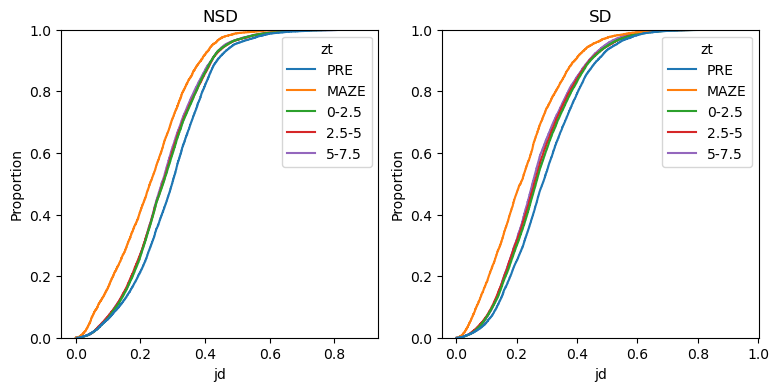

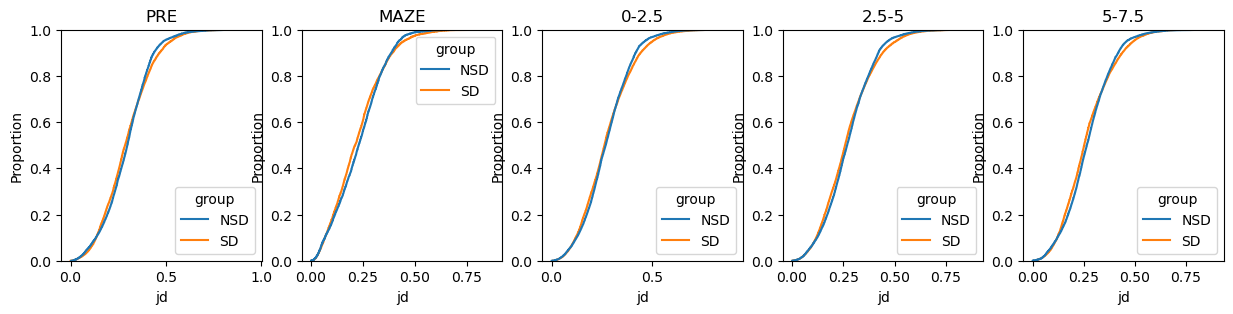

In [45]:
# Compare within groups across epochs
_, ax = plt.subplots(1, 2, figsize=(9, 4))
for a, grp in zip(ax, ["NSD", "SD"]):
    grp_df = replay_df[replay_df.group == grp]
    sns.ecdfplot(data=grp_df, x='jd', hue='zt', ax=a)
    a.set_title(grp)

# Look between groups for each epoch
_, ax = plt.subplots(1, 5, figsize=(15, 3))
for a, zt_label in zip(ax, ['PRE', 'MAZE', '0-2.5', '2.5-5', '5-7.5']):
    epoch_df = replay_df[replay_df.zt == zt_label]
    sns.ecdfplot(data=epoch_df, x='jd', hue='group', hue_order=["NSD", "SD"], ax=a)
    a.set_title(zt_label)